<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook, I used 4 different classification algorithms to predict if a loan application will be paidoff or go into collection. 

The step followed are to load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [48]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing



import random 

import scipy.optimize as opt
import pylab as pl

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets.samples_generator import make_blobs 

from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, f1_score, jaccard_similarity_score
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [49]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-04-28 08:33:18--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-04-28 08:33:18 (12.0 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [50]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [51]:
df.shape

(346, 10)

### Convert to date time object 

In [52]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [53]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [54]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

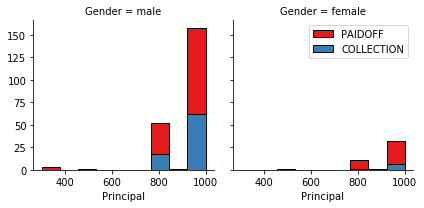

In [55]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

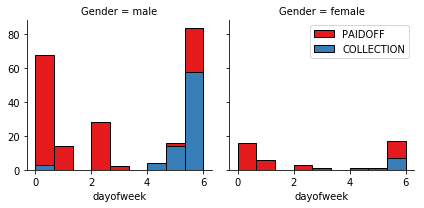

In [56]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [57]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [58]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [59]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [60]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [61]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [62]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [63]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [64]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [65]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

### Training Accuracy Evaluation for K=6

In [66]:
# Perform a train/test split on the data for the K Nearest Neighbor (KNN) Algorithm

In [67]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set for KNN:', X_train_knn.shape,  y_train_knn.shape)
print ('Test set for KNN:', X_test_knn.shape,  y_test_knn.shape)

Train set for KNN: (276, 8) (276,)
Test set for KNN: (70, 8) (70,)


### Training the KNN Model

In [68]:
k = 6
## Train and Predict the model
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train_knn, y_train_knn)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [69]:
y_pred_knn = neigh.predict(X_test_knn)
y_pred_knn[0:5]

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [70]:
from sklearn import metrics
print("Train set Accuracy for KNN: ", metrics.accuracy_score(y_train_knn, neigh.predict(X_train_knn)))
print("Test set Accuracy for KNN: ", metrics.accuracy_score(y_test_knn, y_pred_knn))



Train set Accuracy for KNN:  0.8007246376811594
Test set Accuracy for KNN:  0.7142857142857143


In [71]:
# keep all training and testing scores on a dictionary
training_results = {}

In [72]:
training_results['KNN_Training_Accuracy'] = metrics.accuracy_score(y_train_knn, neigh.predict(X_train_knn))

training_results

{'KNN_Training_Accuracy': 0.8007246376811594}

### Accuracy Evaluation for Different K

In [73]:
Ks = 10
mean_acc = np.zeros((Ks-1))

std_acc = np.zeros((Ks-1))

ConfusionMx = [];

for n in range(1, Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_knn, y_train_knn)
    y_pred_knn = neigh.predict(X_test_knn)
    mean_acc[n-1] = metrics.accuracy_score(y_test_knn, y_pred_knn)

    
    std_acc[n-1] = np.std(y_pred_knn == y_test_knn)/np.sqrt(y_pred_knn.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

### Plot  model accuracy  for Different number of Neighbors 

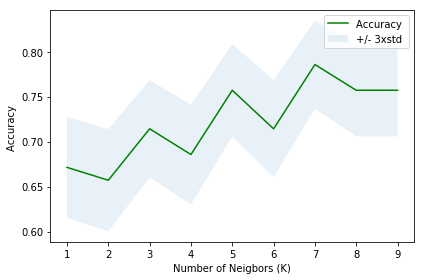

In [74]:
plt.plot(range(1, Ks), mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)

plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neigbors (K)')
plt.tight_layout()
plt.show()

In [75]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


## Retrain with the best K value

In [76]:
k = 7
## Train and Predict the model
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train_knn, y_train_knn)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [77]:
y_pred_knn = neigh.predict(X_test_knn)
y_pred_knn[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [78]:
print("Train set Accuracy for KNN: ", metrics.accuracy_score(y_train_knn, neigh.predict(X_train_knn)))
print("Test set Accuracy for KNN: ", metrics.accuracy_score(y_test_knn, y_pred_knn))


Train set Accuracy for KNN:  0.8079710144927537
Test set Accuracy for KNN:  0.7857142857142857


In [79]:
training_results['KNN_Training_Accuracy'] = metrics.accuracy_score(y_train_knn, neigh.predict(X_train_knn))
training_results['KNN_Test_Accuracy'] = metrics.accuracy_score(y_test_knn, y_pred_knn)
training_results

{'KNN_Training_Accuracy': 0.8079710144927537,
 'KNN_Test_Accuracy': 0.7857142857142857}

In [80]:
# Check f1_score for training accuracy
training_results['KNN_f1_score'] = f1_score(y_test_knn, y_pred_knn, average='weighted') 
# Check jaccard index for training accuracy
training_results['KNN_jaccard'] = jaccard_similarity_score(y_test_knn, y_pred_knn)
training_results

{'KNN_Training_Accuracy': 0.8079710144927537,
 'KNN_Test_Accuracy': 0.7857142857142857,
 'KNN_f1_score': 0.7766540244416351,
 'KNN_jaccard': 0.7857142857142857}

# Decision Tree

Use all data in load.csv file for training the models using the next 3 algorithms; Decision tree, SVM, and Logistic Regression

In [81]:
# X_train, y_train = (X, y)
# print("Train set:", X_train.shape, y_train.shape)

X_traintree, X_testtree, y_traintree, y_testtree = train_test_split( X, y, test_size=0.2, random_state=4)
print('Train set for KNN:', X_traintree.shape,  y_traintree.shape)
print('Test set for KNN:', X_testtree.shape,  y_testtree.shape)


Train set for KNN: (276, 8) (276,)
Test set for KNN: (70, 8) (70,)


Since the data has been split into train and test sets in the K Nearest neighbor model, this step will be skipped and the remaining models for this project will reuse the train/test split.

### Create an Instance of the DecisionTree Classifier

In [82]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
loanTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [83]:
loanTree.fit(X_traintree, y_traintree)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Use trained model to Predict in the Testing dataset

In [84]:
loan_predTree = loanTree.predict(X_testtree)

In [86]:
print(loan_predTree [0:8])
print(y_testtree [0:8])



['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'COLLECTION']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF']


In [87]:
# print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_train, loan_predTree))
# training_results["Dec_Tree_Training_Accuracy"] = metrics.accuracy_score(y_train, loan_predTree)
# training_results

### Obtain Accuracy Classification Score for DecisionTree Model

In [2]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-pyhd1c1de3_3 conda-forge
    python_abi:      3.6-1_cp36m        conda-forge

The following packages will be UPDATED:

 

In [3]:
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
from io import StringIO

In [4]:
dot_data = StringIO()

filename = "loantree.png"

featureNames = df.columns[0:8]
targetNames = df["loan_status"].unique().tolist()

out = tree.export_graphviz(loanTree,feature_names=featureNames, 
                         out_file=dot_data, 
                         class_names= np.unique(y_train), 
                         filled=True, 
                         special_characters=True, 
                         rotate=False)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)

img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img, interpolation='nearest')

NameError: name 'df' is not defined

<!-- ## Evaluate the DecisionTree model accuracy using F1_Score and Jaccard Similarity -->

In [ ]:
# from sklearn.metrics import jaccard_similarity_score
# from sklearn.metrics import f1_score
# from sklearn.metrics import log_loss

In [ ]:
# # Check f1_score for accuracy
# training_results['DecTree_F1'] = f1_score(y_train, loan_predTree, average='weighted') 

# # Check jaccard index for accuracy
# training_results['DecTree_jaccard'] = jaccard_similarity_score(y_train, loan_predTree)
# #training_results

# Support Vector Machine

In [ ]:
X_trainsvm, X_testsvm, y_trainsvm, y_testsvm = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trainsvm.shape,  y_trainsvm.shape)
print ('Test set:', X_testsvm.shape,  y_testsvm.shape)

In [ ]:
#Encode the label values to numeric
df = df[pd.to_numeric(df['education'], errors='coerce').notnull()]

df['education'] = df['education'].astype('int')
df.dtypes

In [ ]:
#y_train=y_train.astype(float)
clf_svm = svm.SVC(kernel='rbf')
clf_svm.fit(X_train, y_train)  



In [ ]:
y_predsvm = clf_svm.predict(X_train)
y_predsvm[0:5]

In [ ]:
# training_results["SVM_Training_Accuracy"] = metrics.accuracy_score(y_train, y_predsvm)
# training_results

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_trainsvm, y_predsvm, labels=[0,1])
np.set_printoptions(precision=2)

print(classification_report(y_trainsvm, y_predsvm))
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PaidOff(0)', 'Collection(1)'], 
                      normalize= False,
                      title='Confusion matrix')

### Evaluate Model Accuracy Using f1-score and Jaccard_similarity for SVM

In [ ]:
# model_results['SVM_F1'] = f1_score(y_testsvm, yhatsvm, average='weighted')
# model_results['SVM_jaccard'] = jaccard_similarity_score(y_testsvm, yhatsvm)
# model_results

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [ ]:
df = df[['loan_status', 'Principal', 'terms', 'effective_date', 'due_date', 'age', 'education', 'Gender']]

#Convert loan_status to numeric
df['loan_status'] = df['loan_status'].astype(int)

In [ ]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X

In [ ]:
#Split the dataset again for the Logistic Regression algorithm

X_trainlog, X_testlog, y_trainlog, y_testlog = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trainlog.shape,  y_trainlog.shape)
print ('Test set:', X_testlog.shape,  y_testlog.shape) 

clf_log = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf_log.fit(X_trainlog, y_trainlog)



In [ ]:
#proba=clf_log.predict_proba(X_test)

In [ ]:
y_pred = clf_log.predict(X_testlog)
y_proba = clf_log.predict_proba(X_testlog)
print(y_pred, y_proba)

In [ ]:
# training_results['LogReg_F1'] = f1_score(y_train, y_pred, average='weighted')  
# training_results['LogReg_jaccard'] = jaccard_similarity_score(y_train, y_pred)
# training_results['LogReg_logLoss'] = log_loss(y_train, y_proba)
# training_results

# Model Evaluation using Test set

In [ ]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation 

In [ ]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

In [ ]:
test_df.shape

In [ ]:
# #Convert to date time object

# test_df['due_date'] = pd.to_datetime(test_df['due_date'])
# test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

# test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)



In [ ]:
test_df.head(10)

In [ ]:
test_df['loan_status'].value_counts()


In [ ]:
# #Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Fram
# Feature = test_df[['Principal','terms','age','Gender','weekend']]
# Feature = pd.concat([Feature, pd.get_dummies(test_df['education'])], axis=1)
# Feature.drop(['Master or Above'], axis = 1,inplace=True)
# Feature.head()

In [ ]:
X_test = preprocessing.StandardScaler().fit_transform(X_test)
X_test

In [ ]:
y_test = test_df["loan_status"].values
y_test[0:5]

In [ ]:
#put the model test results into a dictionary
test_results = {}

In [ ]:
#Test the KNN algorithm
knn_pred_test = neigh.predict(X_test)
test_results['KNN_jaccard'] = jaccard_similarity_score(y_test, knn_pred_test)
test_results['KNN_F1'] = f1_score(y_test, knn_pred_test, average='weighted')
test_results

In [ ]:
# Test the Decision Tree Algorithm
loan_tree_test = loanTree.predict(X_test)


In [ ]:
# training_results['LogReg_F1'] = f1_score(y_test, y_pred, average='weighted')  
# training_results['LogReg_jaccard'] = jaccard_similarity_score(y_test, y_pred)

test_results['DecTree_jaccard'] = jaccard_similarity_score(y_test, loan_tree_test)
test_results['DecTree_F1'] = f1_score(y_test, loan_tree_test, average='weighted')
test_results

In [ ]:
print(loan_tree_test [0:8])
print(y_test[0:8])

In [ ]:
#Test the SVM algorithm
svm_pred = clf_svm.predict(X_test)

In [ ]:
test_results['SVM_jaccard'] = jaccard_similarity_score(y_test, svm_pred)
test_results['SVM_F1'] = f1_score(y_test, svm_pred, average='weighted')
test_results

In [ ]:
#Logistic regression testing

logreg_pred=clf_log.predict(X_test)
y_proba=clf_log.predict_proba(X_test)

In [ ]:
test_results['LogReg_F1'] = f1_score(y_test, logreg_pred, average='weighted')  
test_results['LogReg_jaccard'] = jaccard_similarity_score(y_test, logreg_pred)
test_results['LogReg_logLoss'] = log_loss(y_test, y_proba)
test_results

In [ ]:
#training_results

In [ ]:
test_results

In [ ]:
test_results

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>